### London Airbnb Pricing Model

### This project aims to

 - build models to predict nightly price of Airbnb properties in London using the following types of regression: Linear, Polynomial, LASSO, Ridge
 - determine which features are highly correlated to nightly price and host ratings
 - provide insights and recommendations to Airbnb hosts or those who want to be part of this
 
 
### Data

Dataset used on this project came from Inside Airbnb, an independent provider of Airbnb data. The listings are as of September 2019. 
http://data.insideairbnb.com/united-kingdom/england/london/2019-09-14/data/listings.csv.gz


First, let's import the necessary libraries:

In [81]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set(style="ticks", color_codes=True)
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import eda
import regression as reg
%reload_ext autoreload
%autoreload 2

In [2]:
pd.set_option("display.max_columns", 999)
pd.set_option("display.max_rows", 60)
pd.set_option('max_colwidth', 20)

#### Data Cleaning

In [3]:
#Get the latest listings.csv.gz from http://insideairbnb.com/get-the-data.html
#Then convert it to pandas dataframe

df_london = pd.read_csv("/Users/valmadrid/DataScienceBootcamp/Projects/Mod4/London Airbnb Listing Detailed.csv")
#df_london = pd.read_csv("http://data.insideairbnb.com/united-kingdom/england/london/2019-09-14/data/listings.csv.gz")
df_london.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551.0,https://www.airb...,2.019091e+13,2019-09-15,Arty and Bright ...,Unlike most rent...,Amenities Beddin...,Unlike most rent...,family,Not even 10 minu...,No Smoking (very...,Tons of buses (2...,Guest will have ...,No interaction w...,No Smoking (very...,NaN,NaN,https://a0.musca...,NaN,43039,https://www.airb...,Adriano,2009-10-03,"London, England,...","Hello, I'm a fri...",within an hour,100%,NaN,t,https://a0.musca...,https://a0.musca...,Brixton,3.0,3.0,"['email', 'phone...",t,t,"London, United K...",Brixton,Lambeth,NaN,London,NaN,SW9 8DG,London,"London, United K...",GB,United Kingdom,51.46225,-0.11732,t,Apartment,Entire home/apt,4.0,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",I...",NaN,$88.00,$645.00,"$2,350.00",$400.00,$30.00,2.0,$20.00,2.0,180.0,2,2.0,180.0,180,2.0,180.0,4 days ago,t,19.0,42.0,72.0,344.0,2019-09-15,184.0,1.0,2010-03-21,2019-07-10,92.0,9.0,9.0,10.0,10.0,9.0,9.0,f,NaN,NaN,t,f,strict_14_with_g...,f,t,2.0,2.0,0.0,0.0,1.59
1,13913.0,https://www.airb...,2.019091e+13,2019-09-15,Holiday London D...,My bright double...,"Hello Everyone, ...",My bright double...,business,Finsbury Park is...,For art lovers I...,The flat only a ...,Guest will have ...,I like to have l...,I'm an artist an...,NaN,NaN,https://a0.musca...,NaN,54730,https://www.airb...,Alina,2009-11-16,"London, England,...",I am a Multi-Med...,within an hour,100%,NaN,f,https://a0.musca...,https://a0.musca...,LB of Islington,4.0,4.0,"['email', 'phone...",t,f,"Islington, Great...",LB of Islington,Islington,NaN,Islington,Greater London,N4 3,London,"Islington, Unite...",GB,United Kingdom,51.56802,-0.11121,t,Apartment,Private room,2.0,1.0,1.0,0.0,Real Bed,"{TV,""Cable TV"",W...",538.0,$65.00,$333.00,"$1,176.00",$100.00,$15.00,1.0,$15.00,1.0,29.0,1,1.0,29.0,29,1.0,29.0,5 months ago,t,18.0,48.0,78.0,353.0,2019-09-15,16.0,2.0,2010-08-18,2019-06-10,96.0,9.0,10.0,9.0,10.0,9.0,9.0,f,NaN,NaN,f,f,moderate,f,f,3.0,1.0,2.0,0.0,0.14
2,15400.0,https://www.airb...,2.019091e+13,2019-09-15,Bright Chelsea ...,Lots of windows ...,Bright Chelsea A...,Lots of windows ...,romantic,It is Chelsea.,The building nex...,The underground ...,There are two wa...,If I am in the c...,NO SMOKING PLEAS...,NaN,NaN,https://a0.musca...,NaN,60302,https://www.airb...,Philippa,2009-12-05,"Kensing

In [4]:
df_london.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85274 entries, 0 to 85273
Columns: 106 entries, id to reviews_per_month
dtypes: float64(35), object(71)
memory usage: 69.0+ MB


In [5]:
df_london[df_london.id.duplicated() == True] #Check for duplicate listings
df_london.id = df_london.id.astype("object") #Convert listing ID to data type object

In [ ]:
#Run a profiling report which will help in our initial checks

# london_report = df_london.profile_report(title="London Airbnb Listing Detailed Profiling Report")
# london_report.to_file(output_file="londondetailed.html")

In [6]:
#Based on the profiling report the following columns can be deleted (duplicates, large number of null values, urls, descriptions).  
#Let's run another profiling report to verify.

columns_for_deletion = ["listing_url", "scrape_id", "name", "summary", "space", "description", "neighborhood_overview", "notes", "transit", "access", "interaction", "house_rules", 
           "thumbnail_url", "medium_url", "picture_url", "xl_picture_url", "host_id", "host_url", "host_name", "host_location", "host_about", "host_response_time", 
           "host_response_rate", "host_acceptance_rate", "host_thumbnail_url", "host_picture_url", "host_neighbourhood", "host_listings_count", "first_review",
           "host_total_listings_count", "street", "neighbourhood_group_cleansed", "city", "state", "zipcode", "market", "smart_location", "country_code", "country", 
           "square_feet", "minimum_minimum_nights", "maximum_minimum_nights", "minimum_maximum_nights", "maximum_maximum_nights", "minimum_nights_avg_ntm", 
           "maximum_nights_avg_ntm", "calendar_updated", "has_availability", "calendar_last_scraped", "license", "jurisdiction_names", "is_business_travel_ready"]

df_delete = df_london[columns_for_deletion]
df_delete.head(1)

# delete = df_delete.profile_report(title="Columns For Deletion - Profiling Report")
# delete.to_file(output_file="delete.html")

,listing_url,scrape_id,name,summary,space,description,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,first_review,host_total_listings_count,street,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,square_feet,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,calendar_last_scraped,license,jurisdiction_names,is_business_travel_ready
0,https://www.airb...,2.019091e+13,Arty and Bright ...,Unlike most rent...,Amenities Beddin...,Unlike most rent...,Not even 10 minu...,No Smoking (very...,Tons of buses (2...,Guest will have ...,No interaction w...,No Smoking (very...,NaN,NaN,https://a0.musca...,NaN,43039,https://www.airb...,Adriano,"London, England,...","Hello, I'm a fri...",within an hour,100%,NaN,https://a0.musca...,https://a0.musca...,Brixton,3.0,2010-03-21,3.0,"London, United K...",NaN,London,NaN,SW9 8DG,London,"London, United K...",GB,United Kingdom,NaN,2,2.0,180.0,180,2.0,180.0,4 days ago,t,2019-09-15,NaN,NaN,f


In [7]:
#Now let's delete highly correlated or similar columns and those with only null values

df_londonairbnb = df_london.drop(columns_for_deletion, axis = 1)
df_londonairbnb.dropna(subset = ["id"], axis = 0, inplace = True) #all disctint listings except for one null value
df_londonairbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85273 entries, 0 to 85273
Data columns (total 54 columns):
id                                              85273 non-null object
last_scraped                                    85273 non-null object
experiences_offered                             85273 non-null object
host_since                                      85257 non-null object
host_is_superhost                               85256 non-null object
host_verifications                              85272 non-null object
host_has_profile_pic                            85256 non-null object
host_identity_verified                          85256 non-null object
neighbourhood                                   85272 non-null object
neighbourhood_cleansed                          85272 non-null object
latitude                                        85272 non-null float64
longitude                                       85272 non-null float64
is_location_exact                               8

We have now trimmed down our features. We then proceed to cleaning the zero and null values.

In [8]:
#Noticed that the money columns are object, we then convert them to 'float64'

money_columns = ["price", "weekly_price", "monthly_price", "security_deposit", "cleaning_fee", "extra_people"]
eda.update_money_columns(df_londonairbnb, money_columns)

In [9]:
#Let's first clean the zero and null values of the continuous features

df_londonairbnb.select_dtypes("float64").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85273 entries, 0 to 85273
Data columns (total 33 columns):
latitude                                        85272 non-null float64
longitude                                       85272 non-null float64
accommodates                                    85272 non-null float64
bathrooms                                       85145 non-null float64
bedrooms                                        85230 non-null float64
beds                                            85119 non-null float64
price                                           85272 non-null float64
weekly_price                                    7191 non-null float64
monthly_price                                   5129 non-null float64
security_deposit                                55620 non-null float64
cleaning_fee                                    63743 non-null float64
guests_included                                 85272 non-null float64
extra_people                             

In [10]:
#Delete rows where column has only one nan value

nan_to_delete = ["latitude", "longitude","accommodates", "guests_included", "minimum_nights", "maximum_nights", "availability_365", "calculated_host_listings_count"]
df_londonairbnb.dropna(subset = nan_to_delete, axis = 0, inplace = True)

In [11]:
#Check which proxy to be used for zero and null values

# for col in list(df_londonairbnb.select_dtypes("float64").columns):
#     eda.check_zero_nan(df_londonairbnb[col], replace = "mode")

In [12]:
#bathrooms proxy 1 (mode) for null and zeroes
df_londonairbnb.bathrooms = eda.replace_zero_nan(df_londonairbnb.bathrooms, 1)

#bedrooms proxy 0 for null and zeroes, assume studio type for bedrooms = 0
df_londonairbnb.bedrooms = eda.replace_zero_nan(df_londonairbnb.bedrooms, 0)

#bed proxy 1 (mode) for null and zeroes
df_londonairbnb.beds = eda.replace_zero_nan(df_londonairbnb.beds, 1)

#review scores and count proxy 0 for null
df_londonairbnb.review_scores_rating = eda.replace_zero_nan(df_londonairbnb.review_scores_rating, replace = 0)
df_londonairbnb.review_scores_accuracy = eda.replace_zero_nan(df_londonairbnb.review_scores_accuracy, replace = 0)
df_londonairbnb.review_scores_cleanliness = eda.replace_zero_nan(df_londonairbnb.review_scores_cleanliness, replace = 0)
df_londonairbnb.review_scores_communication = eda.replace_zero_nan(df_londonairbnb.review_scores_communication, replace = 0)
df_londonairbnb.review_scores_checkin = eda.replace_zero_nan(df_londonairbnb.review_scores_checkin, replace = 0)
df_londonairbnb.review_scores_location = eda.replace_zero_nan(df_londonairbnb.review_scores_location, replace = 0)
df_londonairbnb.review_scores_value = eda.replace_zero_nan(df_londonairbnb.review_scores_value, replace = 0)
df_londonairbnb.reviews_per_month = eda.replace_zero_nan(df_londonairbnb.reviews_per_month, replace = 0)

#prices proxy 0 for null values
df_londonairbnb.weekly_price = eda.replace_zero_nan(df_londonairbnb.weekly_price, 0)
df_londonairbnb.monthly_price = eda.replace_zero_nan(df_londonairbnb.monthly_price, 0)
df_londonairbnb.security_deposit = eda.replace_zero_nan(df_londonairbnb.security_deposit, 0)
df_londonairbnb.cleaning_fee = eda.replace_zero_nan(df_londonairbnb.cleaning_fee, 0)

#reviews_per_month proxy 0 for null values
df_londonairbnb.reviews_per_month = eda.replace_zero_nan(df_londonairbnb.reviews_per_month, 0)

#Check if all float columns have been dealt with
df_londonairbnb.select_dtypes("float64").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85272 entries, 0 to 85273
Data columns (total 33 columns):
latitude                                        85272 non-null float64
longitude                                       85272 non-null float64
accommodates                                    85272 non-null float64
bathrooms                                       85272 non-null float64
bedrooms                                        85272 non-null float64
beds                                            85272 non-null float64
price                                           85272 non-null float64
weekly_price                                    85272 non-null float64
monthly_price                                   85272 non-null float64
security_deposit                                85272 non-null float64
cleaning_fee                                    85272 non-null float64
guests_included                                 85272 non-null float64
extra_people                           

In [13]:
#Next, let's clean the null values of the categorical columns

df_londonairbnb.select_dtypes("object").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85272 entries, 0 to 85273
Data columns (total 21 columns):
id                                  85272 non-null object
last_scraped                        85272 non-null object
experiences_offered                 85272 non-null object
host_since                          85256 non-null object
host_is_superhost                   85256 non-null object
host_verifications                  85272 non-null object
host_has_profile_pic                85256 non-null object
host_identity_verified              85256 non-null object
neighbourhood                       85272 non-null object
neighbourhood_cleansed              85272 non-null object
is_location_exact                   85272 non-null object
property_type                       85272 non-null object
room_type                           85272 non-null object
bed_type                            85272 non-null object
amenities                           85272 non-null object
last_review          

In [14]:
#Check which proxy to be used for zero and null values

# for col in list(df_londonairbnb.select_dtypes("object").columns):
#     eda.check_zero_nan_object(df_londonairbnb[col])

In [15]:
#Update categorical columns with values 't' and 'f', then change dtype to 'int64'

t_or_f = ["host_is_superhost", "host_has_profile_pic", "host_identity_verified", "is_location_exact", "require_guest_phone_verification",
         "require_guest_profile_picture", "instant_bookable", "requires_license"]

eda.binary_col(df_londonairbnb, t_or_f)
df_londonairbnb[t_or_f].head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,is_location_exact,require_guest_phone_verification,require_guest_profile_picture,instant_bookable,requires_license
0,1,1,1,1,1,0,1,0
1,0,1,0,1,0,0,0,0
2,1,1,1,1,1,1,1,0
3,1,1,1,1,0,0,1,0
4,0,1,1,1,1,1,0,0


In [16]:
df_londonairbnb.select_dtypes("object").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85272 entries, 0 to 85273
Data columns (total 13 columns):
id                        85272 non-null object
last_scraped              85272 non-null object
experiences_offered       85272 non-null object
host_since                85256 non-null object
host_verifications        85272 non-null object
neighbourhood             85272 non-null object
neighbourhood_cleansed    85272 non-null object
property_type             85272 non-null object
room_type                 85272 non-null object
bed_type                  85272 non-null object
amenities                 85272 non-null object
last_review               64269 non-null object
cancellation_policy       85272 non-null object
dtypes: object(13)
memory usage: 9.1+ MB


In [18]:
#Delete nan value under host_since

df_londonairbnb.dropna(subset = ["host_since"], axis = 0, inplace = True)

#Convert 'host_since' and 'last_review' to number of days
#Delete 'host_since' and 'last_review' column

df_londonairbnb['host_days'] = pd.to_datetime(df_londonairbnb['last_scraped']) - pd.to_datetime(df_londonairbnb['host_since'])
df_londonairbnb["days_from_last_review"] = pd.to_datetime(df_londonairbnb['last_scraped']) - pd.to_datetime(df_london['last_review'])
df_londonairbnb['host_days'] = df_londonairbnb['host_days']/ np.timedelta64(1, 'D')
df_londonairbnb["days_from_last_review"] = df_londonairbnb["days_from_last_review"] / np.timedelta64(1, 'D')
df_londonairbnb["days_from_last_review"].fillna(value = 0, inplace = True)
df_londonairbnb.drop(columns = ["last_review", "host_since", "last_scraped"], axis = 1, inplace = True)

In [19]:
#Transform amenities to count of amenities

df_londonairbnb['amenities_count'] = df_londonairbnb.amenities.map(lambda x: len(x.replace('{', '').replace('}', ',').replace('"', '').split(',')))
df_londonairbnb.drop(columns = ["amenities"], axis = 1, inplace = True)

In [20]:
#Transform host_verifications to count

df_londonairbnb.host_verifications = df_londonairbnb.host_verifications.map(lambda x: len(x.replace('[', '').replace(']', '').replace("'", '').split(',')))

In [21]:
#Now we have 0 null values except for 'last_review'

df_londonairbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85256 entries, 0 to 85273
Data columns (total 53 columns):
id                                              85256 non-null object
experiences_offered                             85256 non-null object
host_is_superhost                               85256 non-null int64
host_verifications                              85256 non-null int64
host_has_profile_pic                            85256 non-null int64
host_identity_verified                          85256 non-null int64
neighbourhood                                   85256 non-null object
neighbourhood_cleansed                          85256 non-null object
latitude                                        85256 non-null float64
longitude                                       85256 non-null float64
is_location_exact                               85256 non-null int64
property_type                                   85256 non-null object
room_type                                       85256 

In [22]:
#Let's save the cleaned data

df_londonairbnb.to_csv("londonairbnb_cleaned.csv", index = False)

#### Outliers and EDA

In [23]:
#Remove outliers from the continuous features

df_londonairbnb_cf = df_londonairbnb.select_dtypes(["int64","float64"]).drop(["host_is_superhost", "host_has_profile_pic", "host_identity_verified", "is_location_exact", "require_guest_phone_verification",
         "require_guest_profile_picture", "instant_bookable", "requires_license","weekly_price", "monthly_price"], axis = 1)
df_londonairbnb_cf.columns

Index(['host_verifications', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
       'host_days', 'days_from_last_review', 'amenities_count'],
      dtype='object')

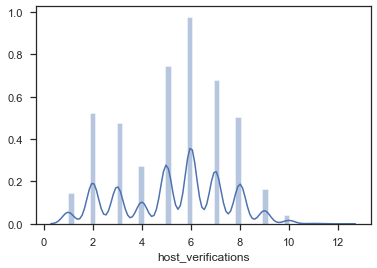

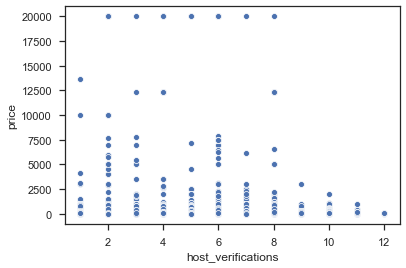

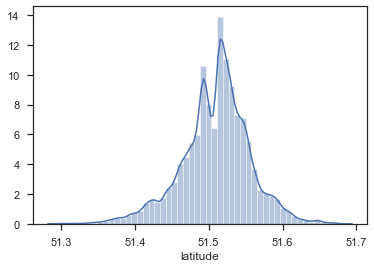

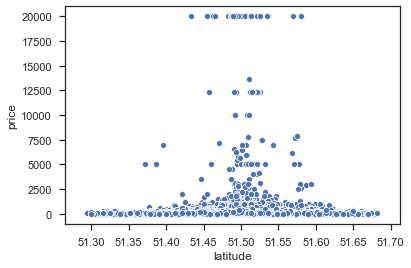

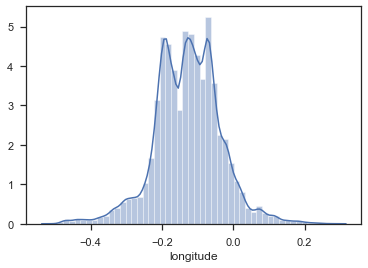

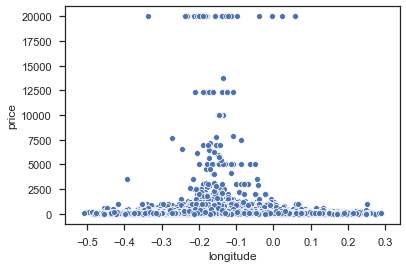

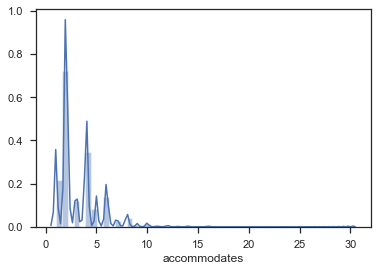

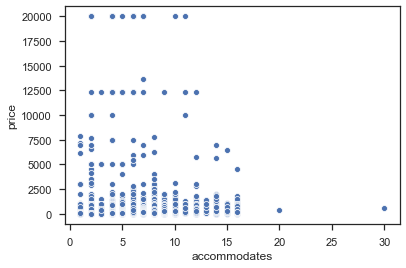

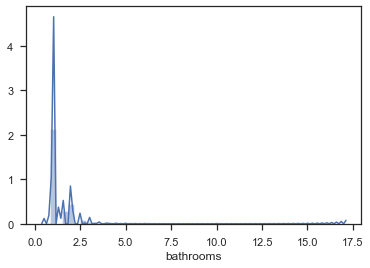

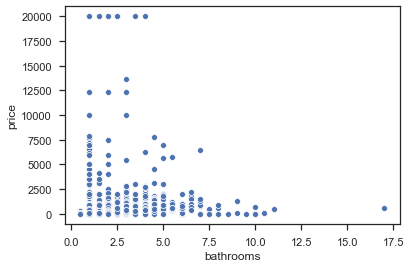

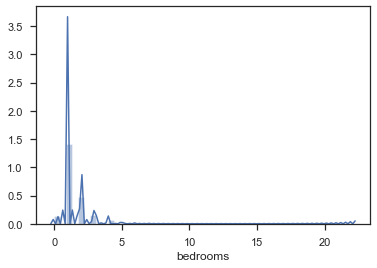

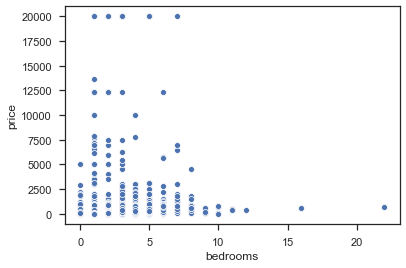

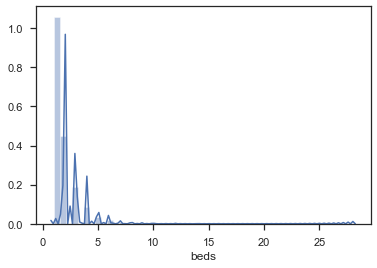

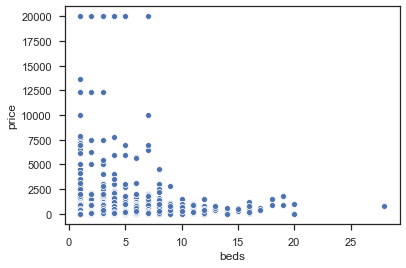

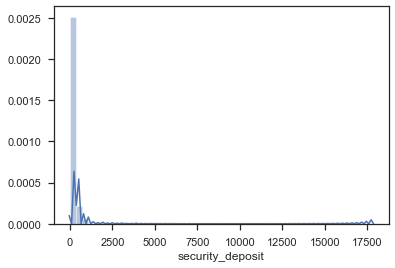

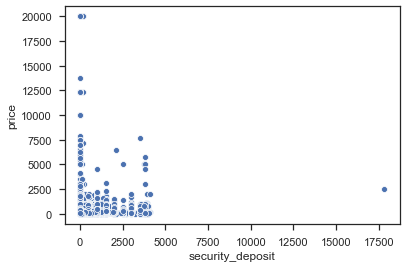

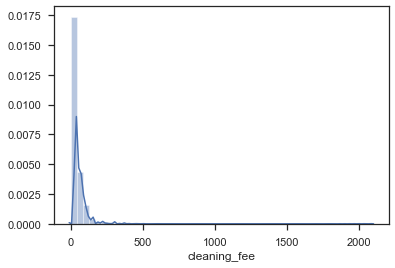

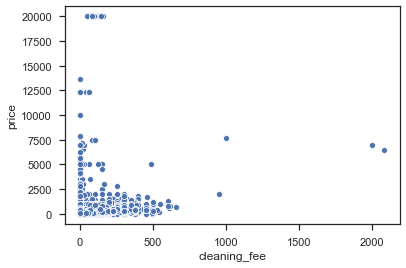

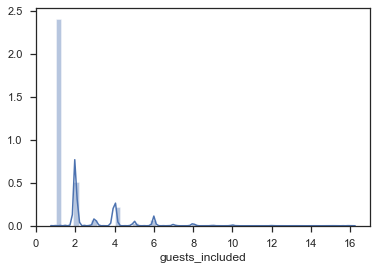

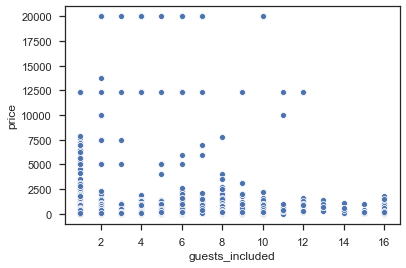

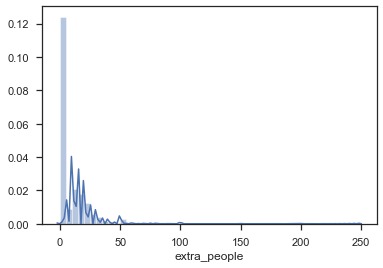

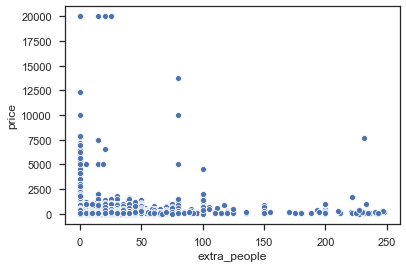

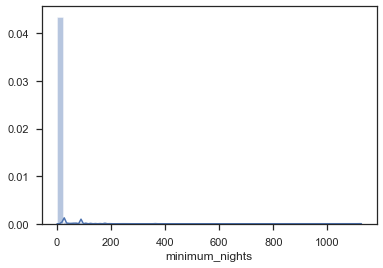

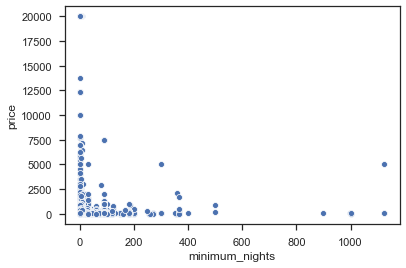

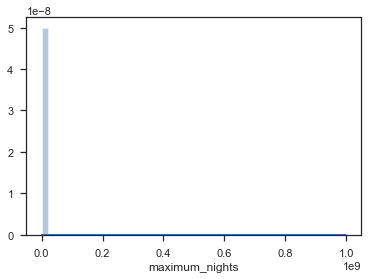

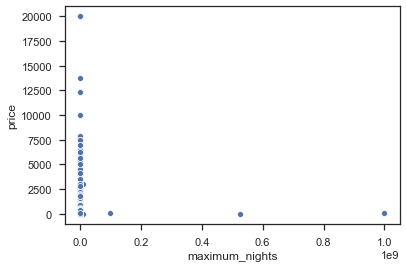

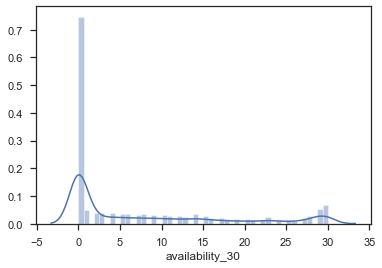

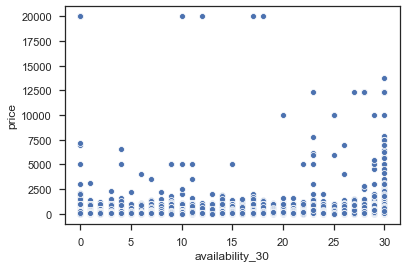

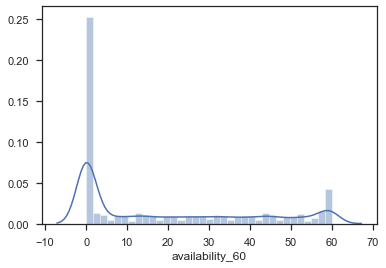

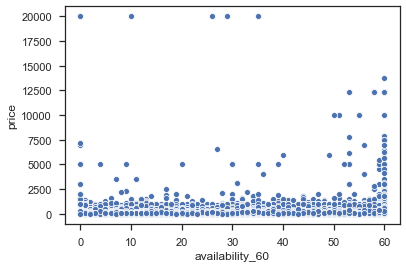

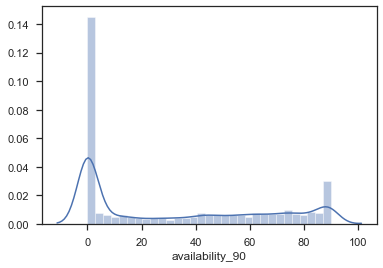

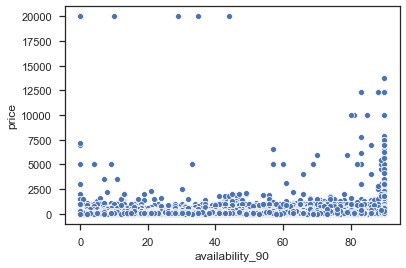

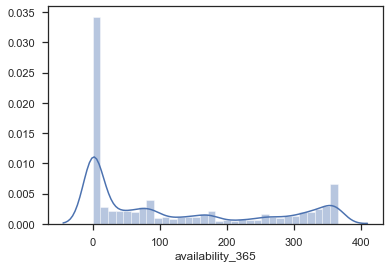

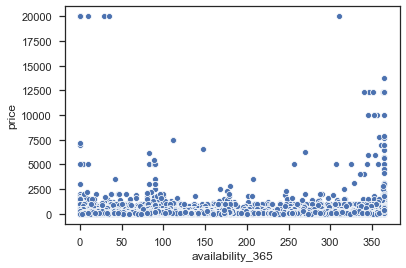

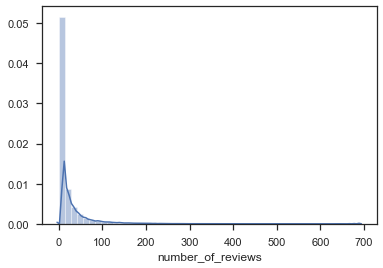

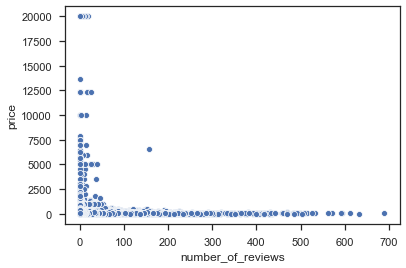

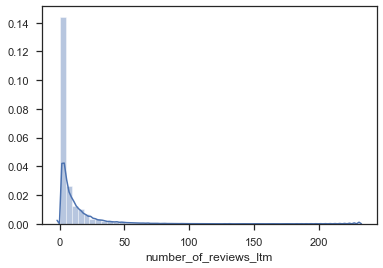

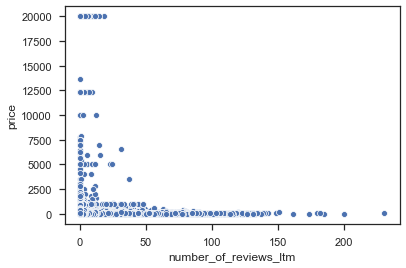

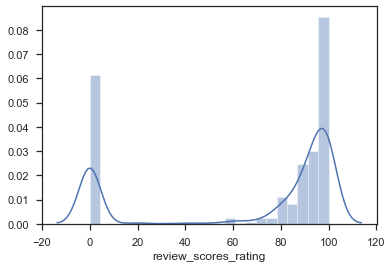

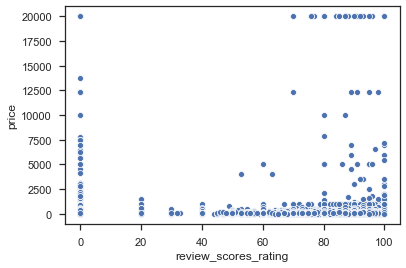

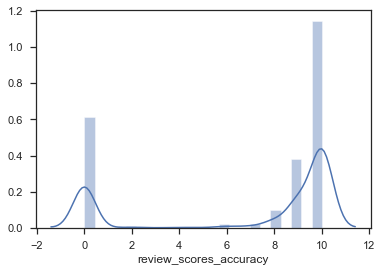

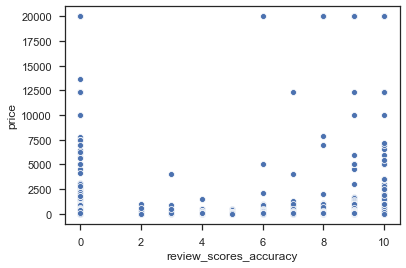

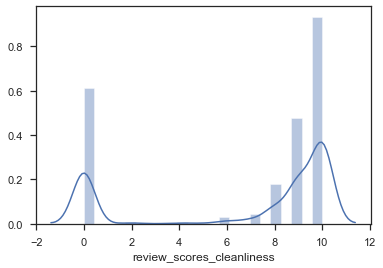

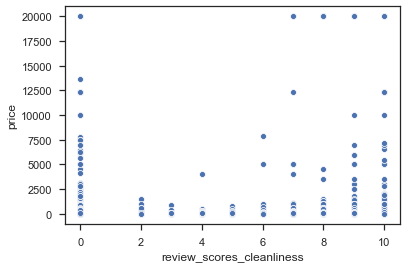

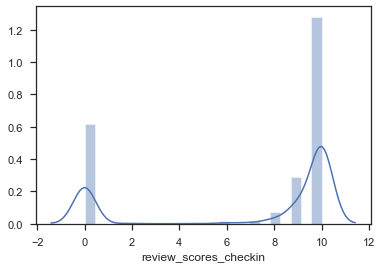

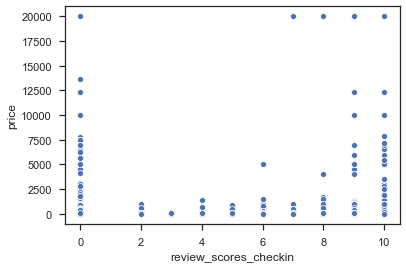

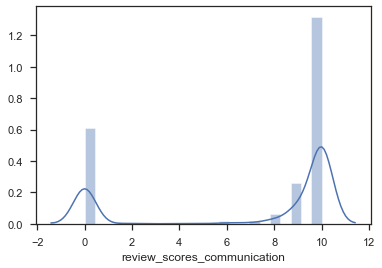

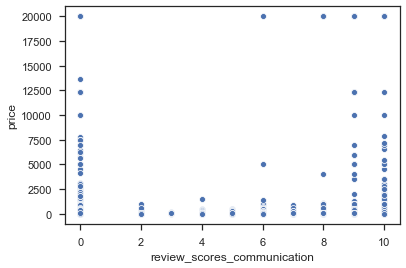

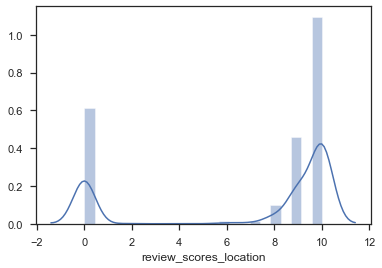

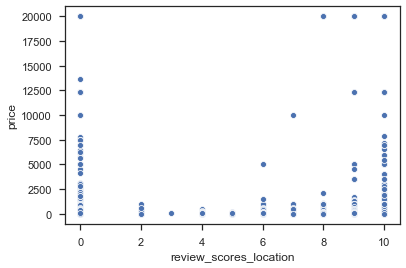

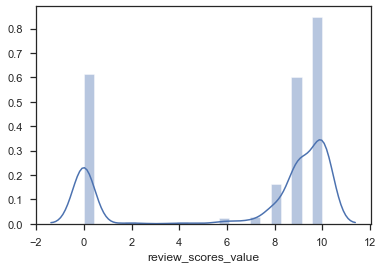

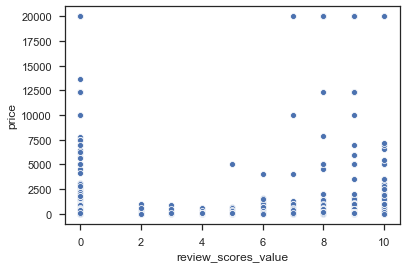

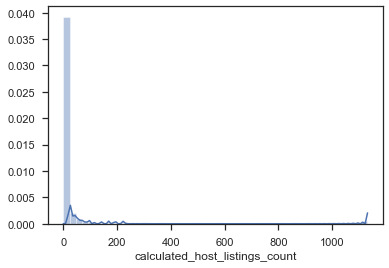

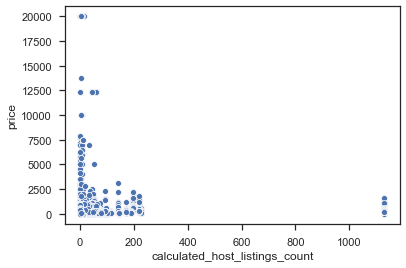

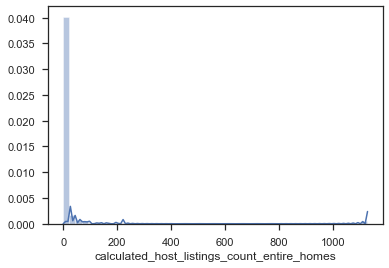

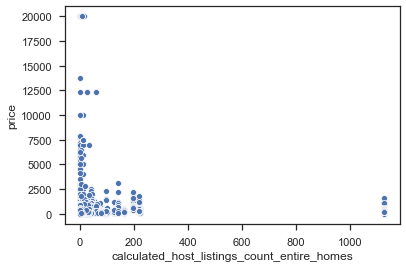

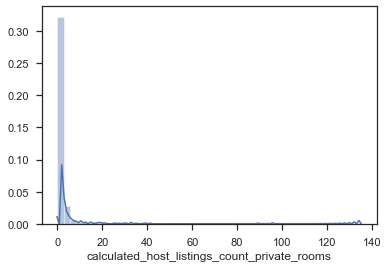

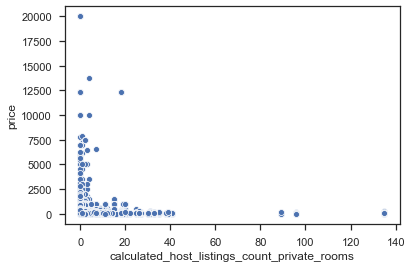

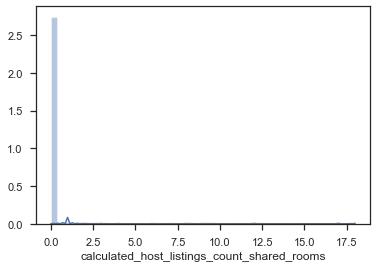

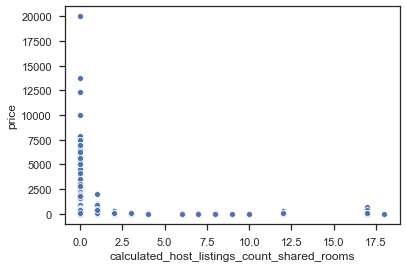

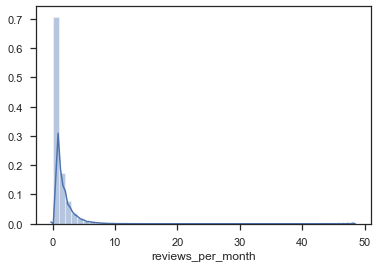

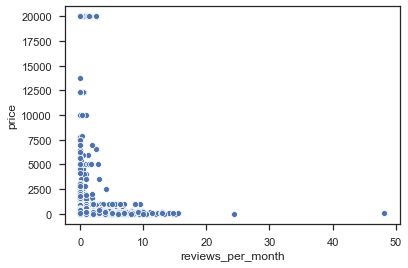

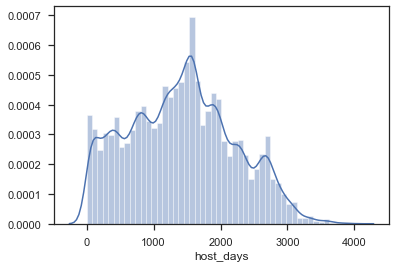

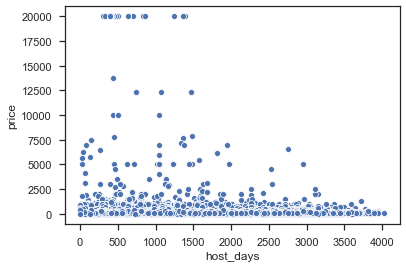

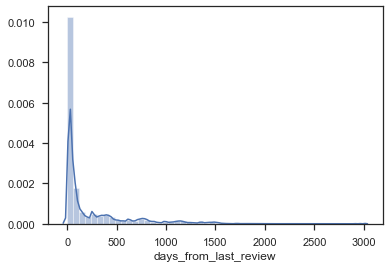

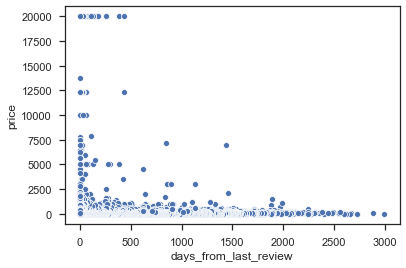

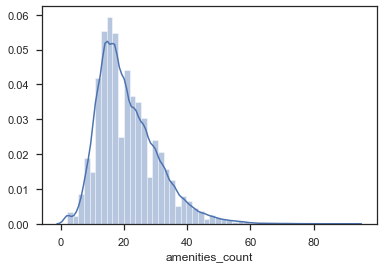

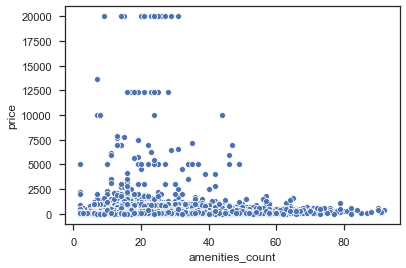

In [24]:
#For each, check the distribution and plot againts 'price' (predictor)

columns = list(df_londonairbnb_cf.columns)
columns.remove("price")

for i, col in enumerate(columns):
    sns.distplot(df_londonairbnb_cf[col])
    plt.show();
    sns.scatterplot(x=col, y="price", data=df_londonairbnb_cf)
    plt.show();

In [25]:
#Systematically remove the outliers using z-score.  Here we are removing data outside of +/-3 std

df_londonairbnb_cf_cleaned = df_londonairbnb_cf[(np.abs(stats.zscore(df_londonairbnb_cf)) < 3).all(axis = 1)]
df_londonairbnb_cf_cleaned.head()

,host_verifications,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_days,days_from_last_review,amenities_count
2,5,51.48796,-0.16898,2.0,1.0,1.0,1.0,100.0,150.0,50.0,2.0,0.0,30.0,50.0,8.0,8.0,8.0,114.0,87.0,6.0,96.0,10.0,10.0,10.0,10.0,10.0,9.0,1.0,1.0,0.0,0.0,0.73,3571.0,19.0,29
3,9,51.52098,-0.14002,6.0,2.0,3.0,4.0,300.0,350.0,65.0,4.0,10.0,3.0,365.0,12.0,36.0,54.0,265.0,41.0,5.0,94.0,10.0,9.0,9.0,9.0,10.0,9.0,15.0,15.0,0.0,0.0,0.40,3541.0,88.0,31
4,6,51.47298,-0.16376,2.0,1.5,1.0,1.0,175.0,250.0,70.0,2.0,0.0,30.0,1125.0,11.0,41.0,71.0,346.0,93.0,1.0,98.0,10.0,10.0,10.0,10.0,9.0,9.0,1.0,1.0,0.0,0.0,0.86,3639.0,99.0,27
6,7,51.57224,-0.20906,2.0,1.5,1.0,1.0,29.0,100.0,0.0,1.0,8.0,10.0,1120.0,12.0,12.0,26.0,288.0,122.0,5.0,95.0,10.0,10.0,10.0,10.0,9.0,10.0,3.0,0.0,3.0,0.0,1.06,3450.0,79.0,17
7,8,51.54168,-0.10207,4.0,1.0,1.0,3.0,147.0,100.0,75.0,3.0,15.0,3.0,365.0,13.0,34.0,64.0,339.0,63.0,9.0,85.0,8.0,9.0,9.0,9.0,9.0,8.0,3.0,3.0,0.0,0.0,0.58,3436.0,55.0,36


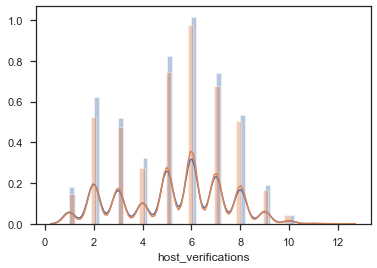

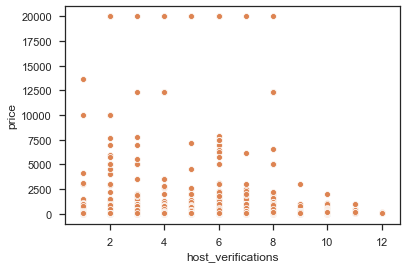

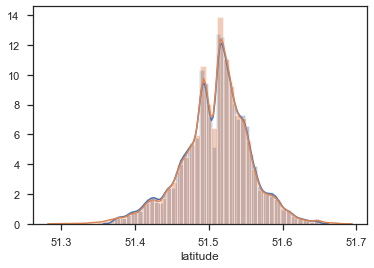

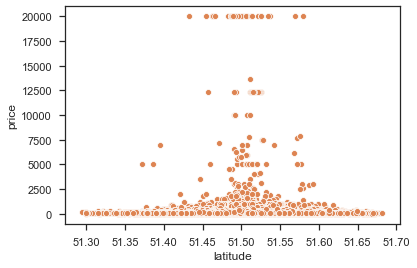

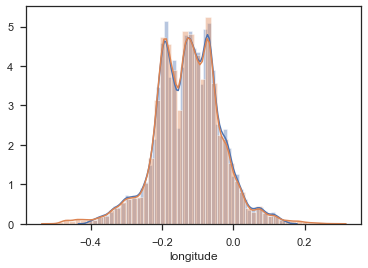

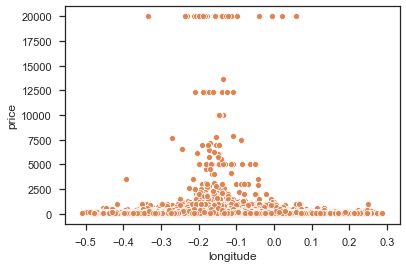

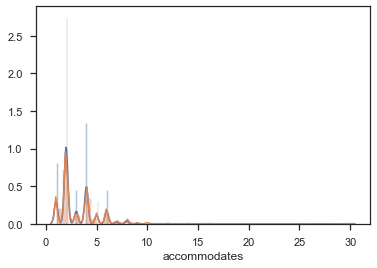

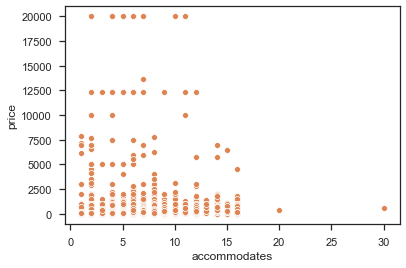

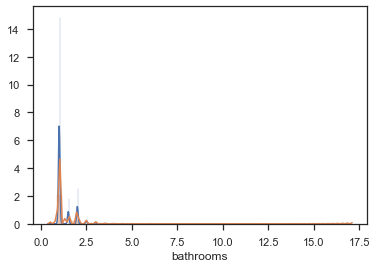

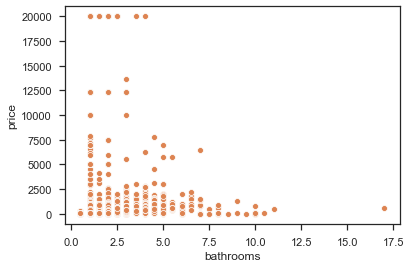

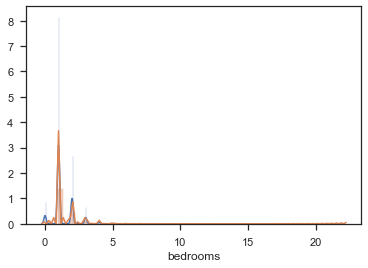

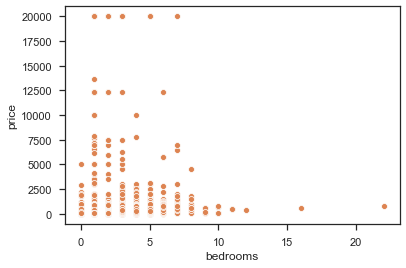

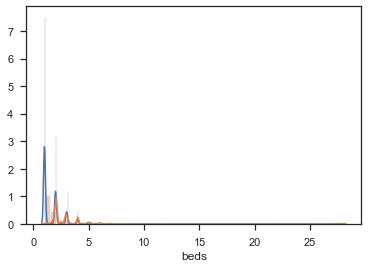

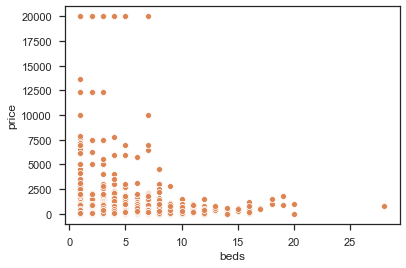

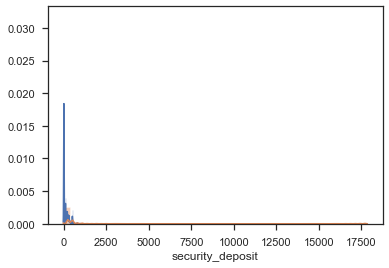

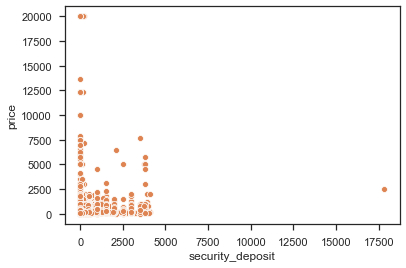

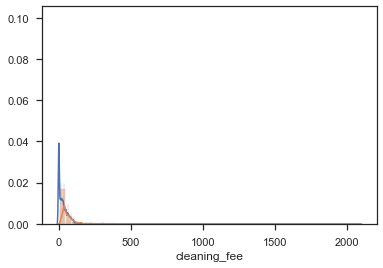

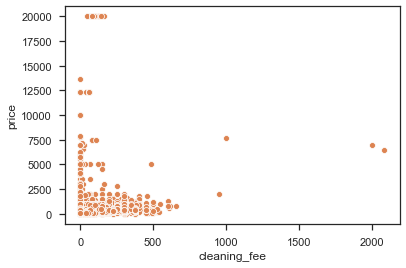

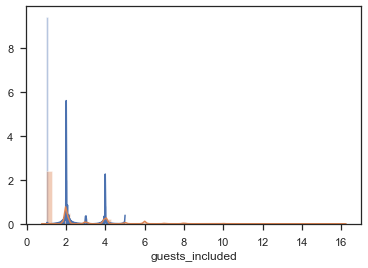

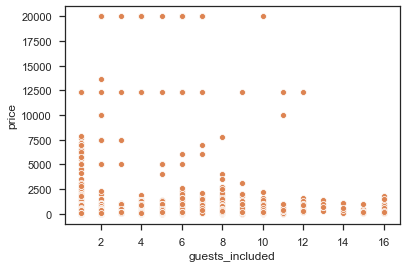

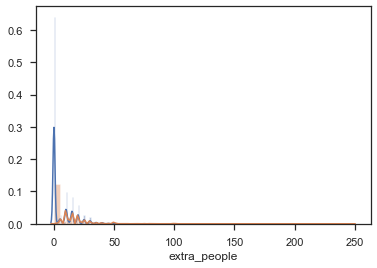

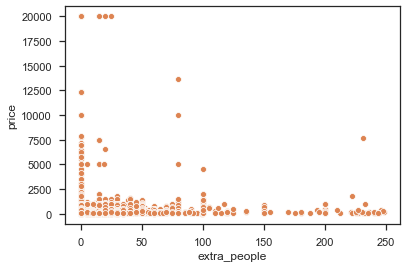

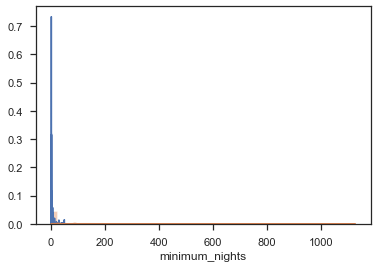

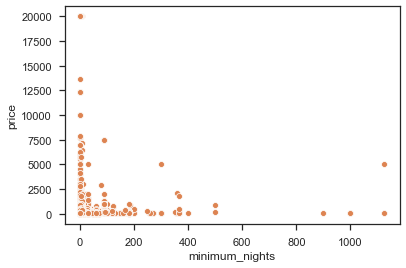

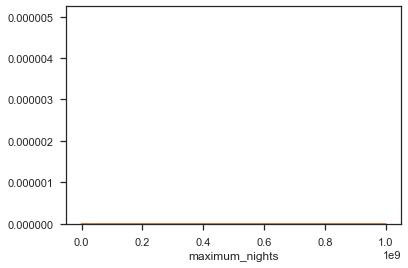

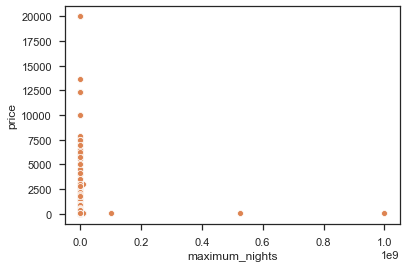

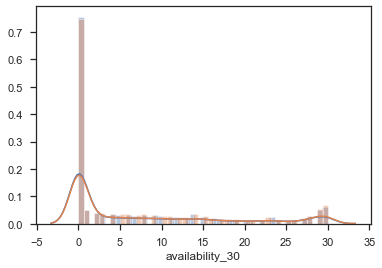

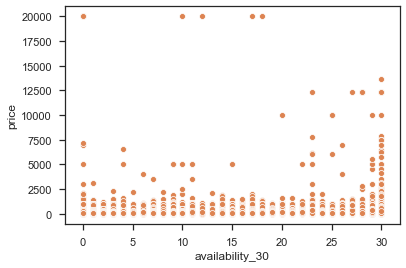

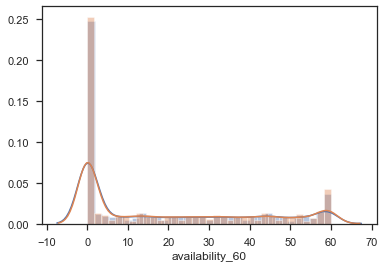

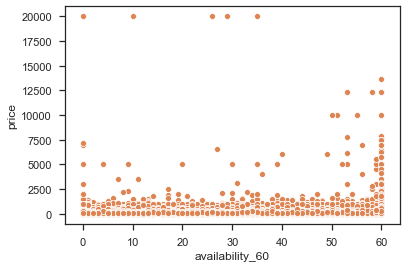

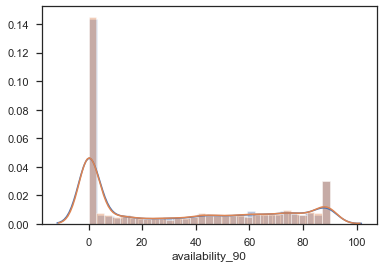

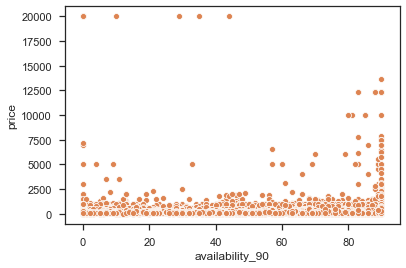

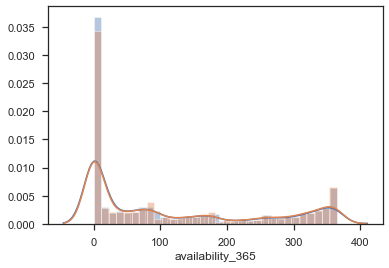

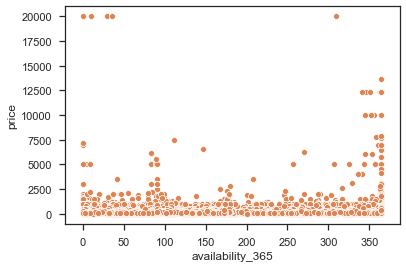

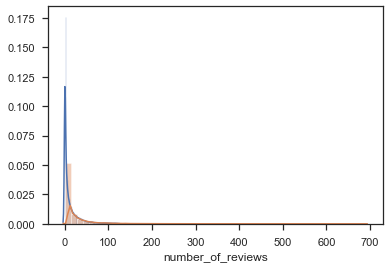

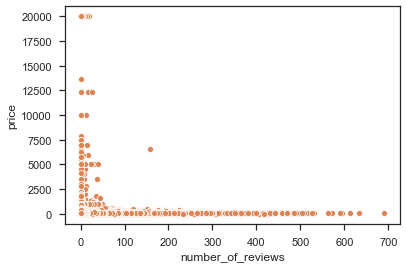

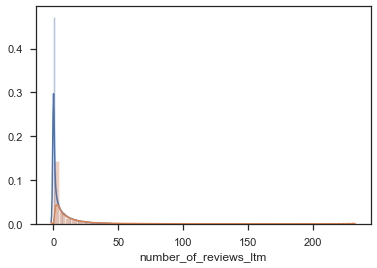

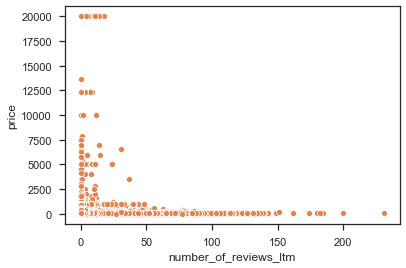

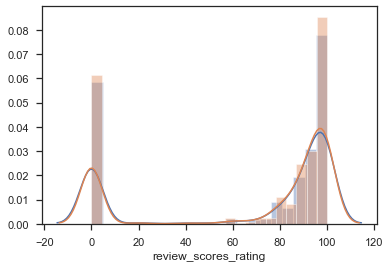

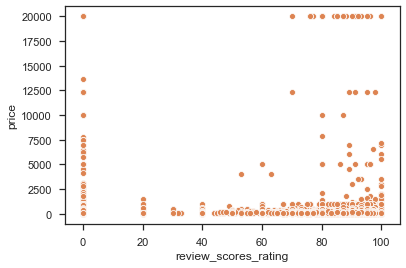

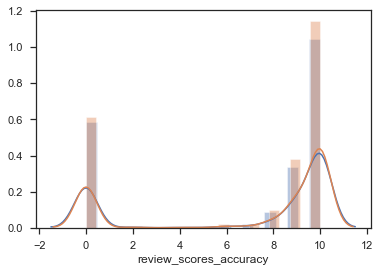

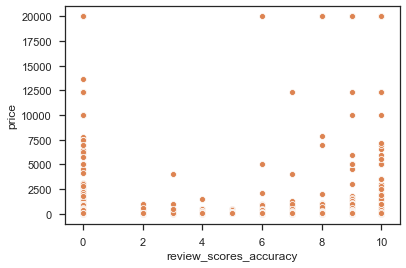

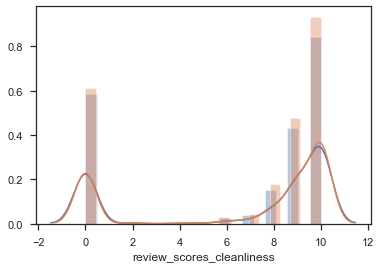

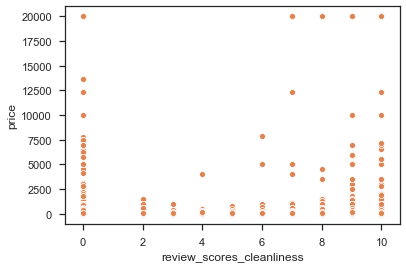

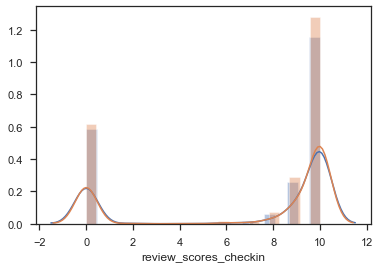

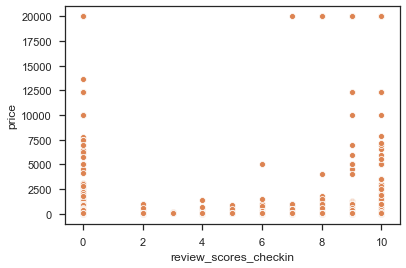

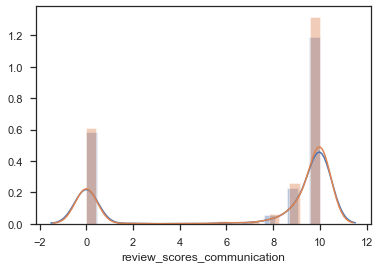

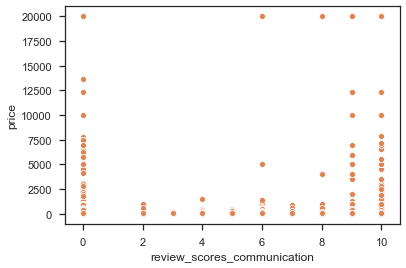

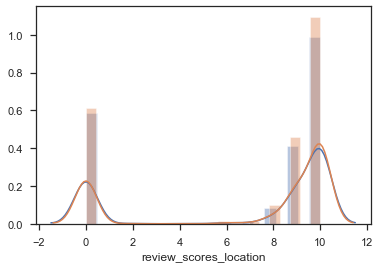

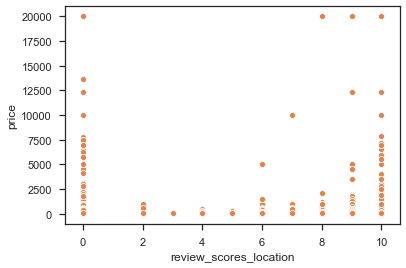

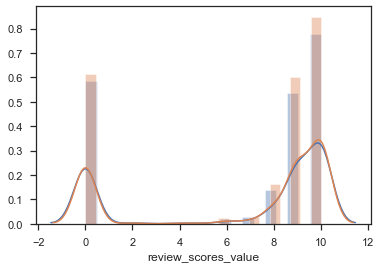

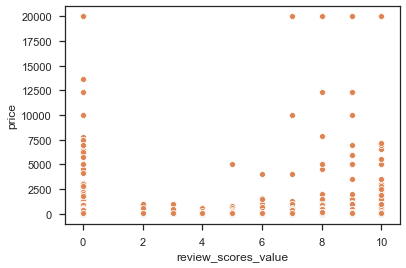

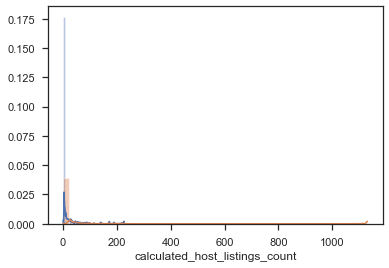

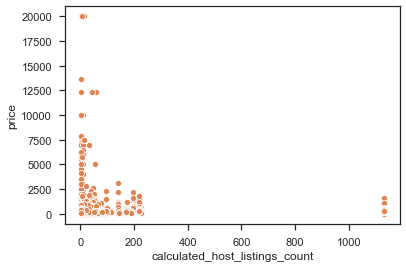

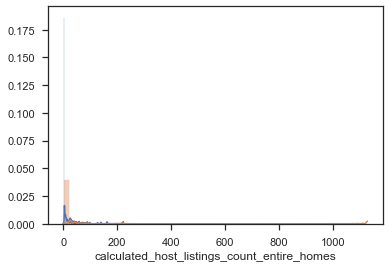

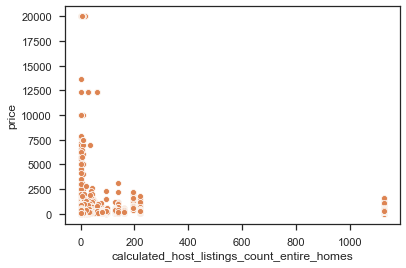

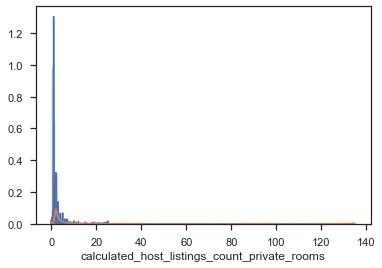

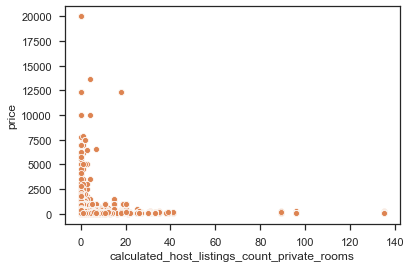

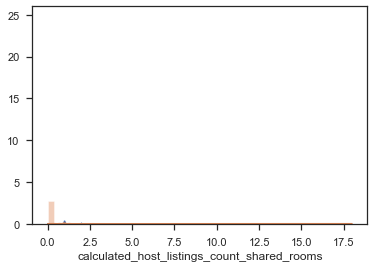

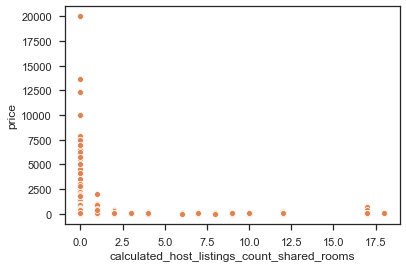

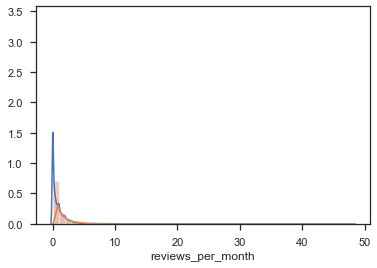

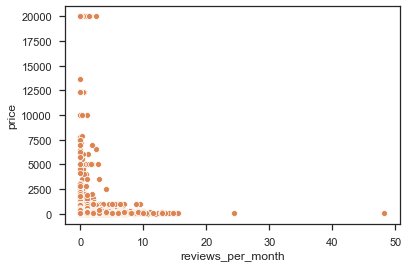

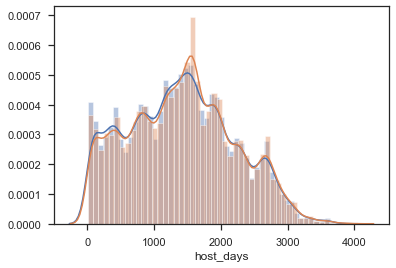

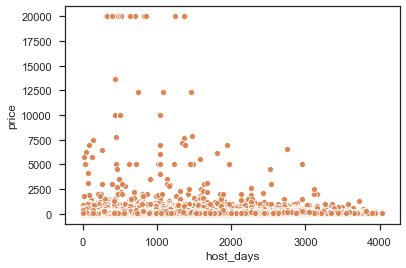

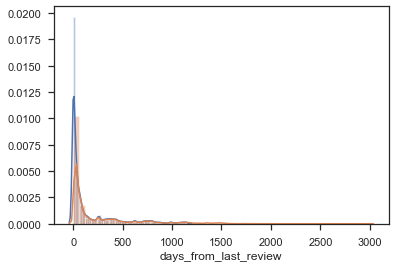

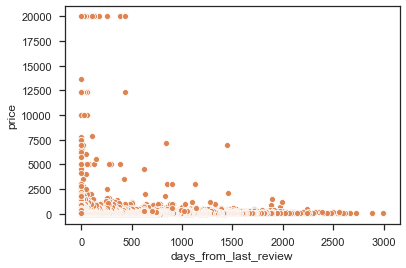

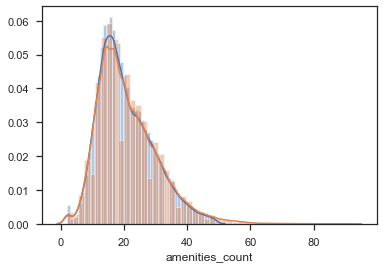

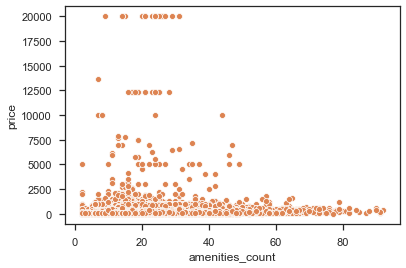

In [26]:
#Let's plot them again

columns = list(df_londonairbnb_cf_cleaned.columns)
columns.remove("price")

for col in columns:
    sns.distplot(df_londonairbnb_cf_cleaned[col])
    sns.distplot(df_londonairbnb_cf[col])
    plt.show();
    sns.scatterplot(x=col, y="price", data=df_londonairbnb_cf_cleaned)
    sns.scatterplot(x=col, y="price", data=df_londonairbnb_cf)
    plt.show();

In [27]:
#Merge the updated continuous feature table to the original table

df_londonairbnb_final = pd.concat([df_londonairbnb_cf_cleaned.price, df_londonairbnb_cf_cleaned.drop(["price"], axis = 1), df_londonairbnb.drop(df_londonairbnb_cf_cleaned.columns, axis = 1)], axis = 1, join = "inner")
df_londonairbnb_final

,price,host_verifications,latitude,longitude,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_days,days_from_last_review,amenities_count,id,experiences_offered,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,is_location_exact,property_type,room_type,bed_type,weekly_price,monthly_price,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
2,100.0,5,51.48796,-0.16898,2.0,1.0,1.0,1.0,150.0,50.0,2.0,0.0,30.0,50.0,8.0,8.0,8.0,114.0,87.0,6.0,96.0,10.0,10.0,10.0,10.0,10.0,9.0,1.0,1.0,0.0,0.0,0.73,3571.0,19.0,29,15400,romantic,1,1,1,Chelsea,Kensington and C...,1,Apartment,Entire home/apt,Real Bed,600.0,2250.0,0,1,strict_14_with_g...,1,1
3,300.0,9,51.52098,-0.14002,6.0,2.0,3.0,4.0,350.0,65.0,4.0,10.0,3.0,365.0,12.0,36.0,54.0,265.0,41.0,5.0,94.0,10.0,9.0,9.0,9.0,10.0,9.0,15.0,15.0,0.0,0.0,0.40,3541.0,88.0,31,17402,none,1,1,1,City of Westminster,Westminster,1,Apartment,Entire home/apt,Real Bed,1378.0,0.0,0,1,strict_14_with_g...,0,0
4,175.0,6,51.47298,-0.16376,2.0,1.5,1.0,1.0,250.0,70.0,2.0,0.0,30.0,1125.0,11.0,41.0,71.0,346.0,93.0,1.0,98.0,10.0,10.0,10.0,10.0,9.0,9.0,1.0,1.0,0.0,0.0,0.86,3639.0,99.0,27,24328,family,0,1,1,LB of Wandsworth,Wandsworth,1,Townhouse,Entire home/apt,Real Bed,1050.0,3500.0,0,0,moderate,1,1
6,29.0,7,51.57224,-0.20906,2.0,1.5,1.0,1.0,100.0,0.0,1.0,8.0,10.0,1120.0,12.0,12.0,26.0,288.0,122.0,5.0,95.0,10.0,10.0,10.0,10.0,9.0,10.0,3.0,0.0,3.0,0.0,1.06,3450.0,79.0,17,25123,none,1,1,0,LB of Barnet,Barnet,1,House,Private room,Real Bed,195.0,795.0,0,1,strict_14_with_g...,0,0
7,147.0,8,51.54168,-0.10207,4.0,1.0,1.0,3.0,100.0,75.0,3.0,15.0,3.0,365.0,13.0,34.0,64.0,339.0,63.0,9.0,85.0,8.0,9.0,9.0,9.0,9.0,8.0,3.0,3.0,0.0,0.0,0.58,3436.0,55.0,36,26223,none,0,1,1,LB of Islington,Islington,1,Apartment,Entire home/apt,Real Bed,727.0,2747.0,0,1,strict_14_with_g...,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85267,30.0,2,51.62711,-0.12502,2.0,1.0,1.0,1.0,100.0,0.0,1.0,0.0,2.0,1125.0,13.0,43.0,73.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.00,133.0,0.0,14,3.86113e+07,none,0,1,0,LB of Enfield,Enfield,1,Apartment,Entire home/apt,Real Bed,0.0,0.0,0,1,strict_14_with_g...,0,0
85268,56.0,4,51.51357,-0.20563,2.0,1.0,2.0,2.0,0.0,0.0,1.0,0.0,6.0,1125.0,15.0,17.0,30.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.00,2564.0,0.0,14,3.86119e+07,none,0,1,0,Notting Hill,Kensington and C...,0,Apartment,Private room,Real Bed,0.0,0.0,0,1,flexible,0,0
85269,85.0,6,51.51383,-0.27288,5.0,1.5,1.0,3.0,0.0,40.0,1.0,0.0,2.0,1125.0,7.0,20.0,38.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,7.0,0.0,0.0,0.00,415.0,0.0,15,3.86123e+07,none,0,1,0,LB of Ealing,Ealing,0,Apartment,Entire home/apt,Real Bed,0.0,0.0,0,1,flexible,0,0
85270,35.0,5,51.55569,-0.21251,2.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1125.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.00,733.0,0.0,16,3.86124e+07,none,0,1,0,Hampstead,Camden,0,Apartment,Private room,Real Bed,0.0,0.0,0,0,flexible,0,0


In [28]:
#Let's save the data post removal of outliers

df_londonairbnb_final.to_csv("londonairbnb_cleaned_outliers.csv", index = False)

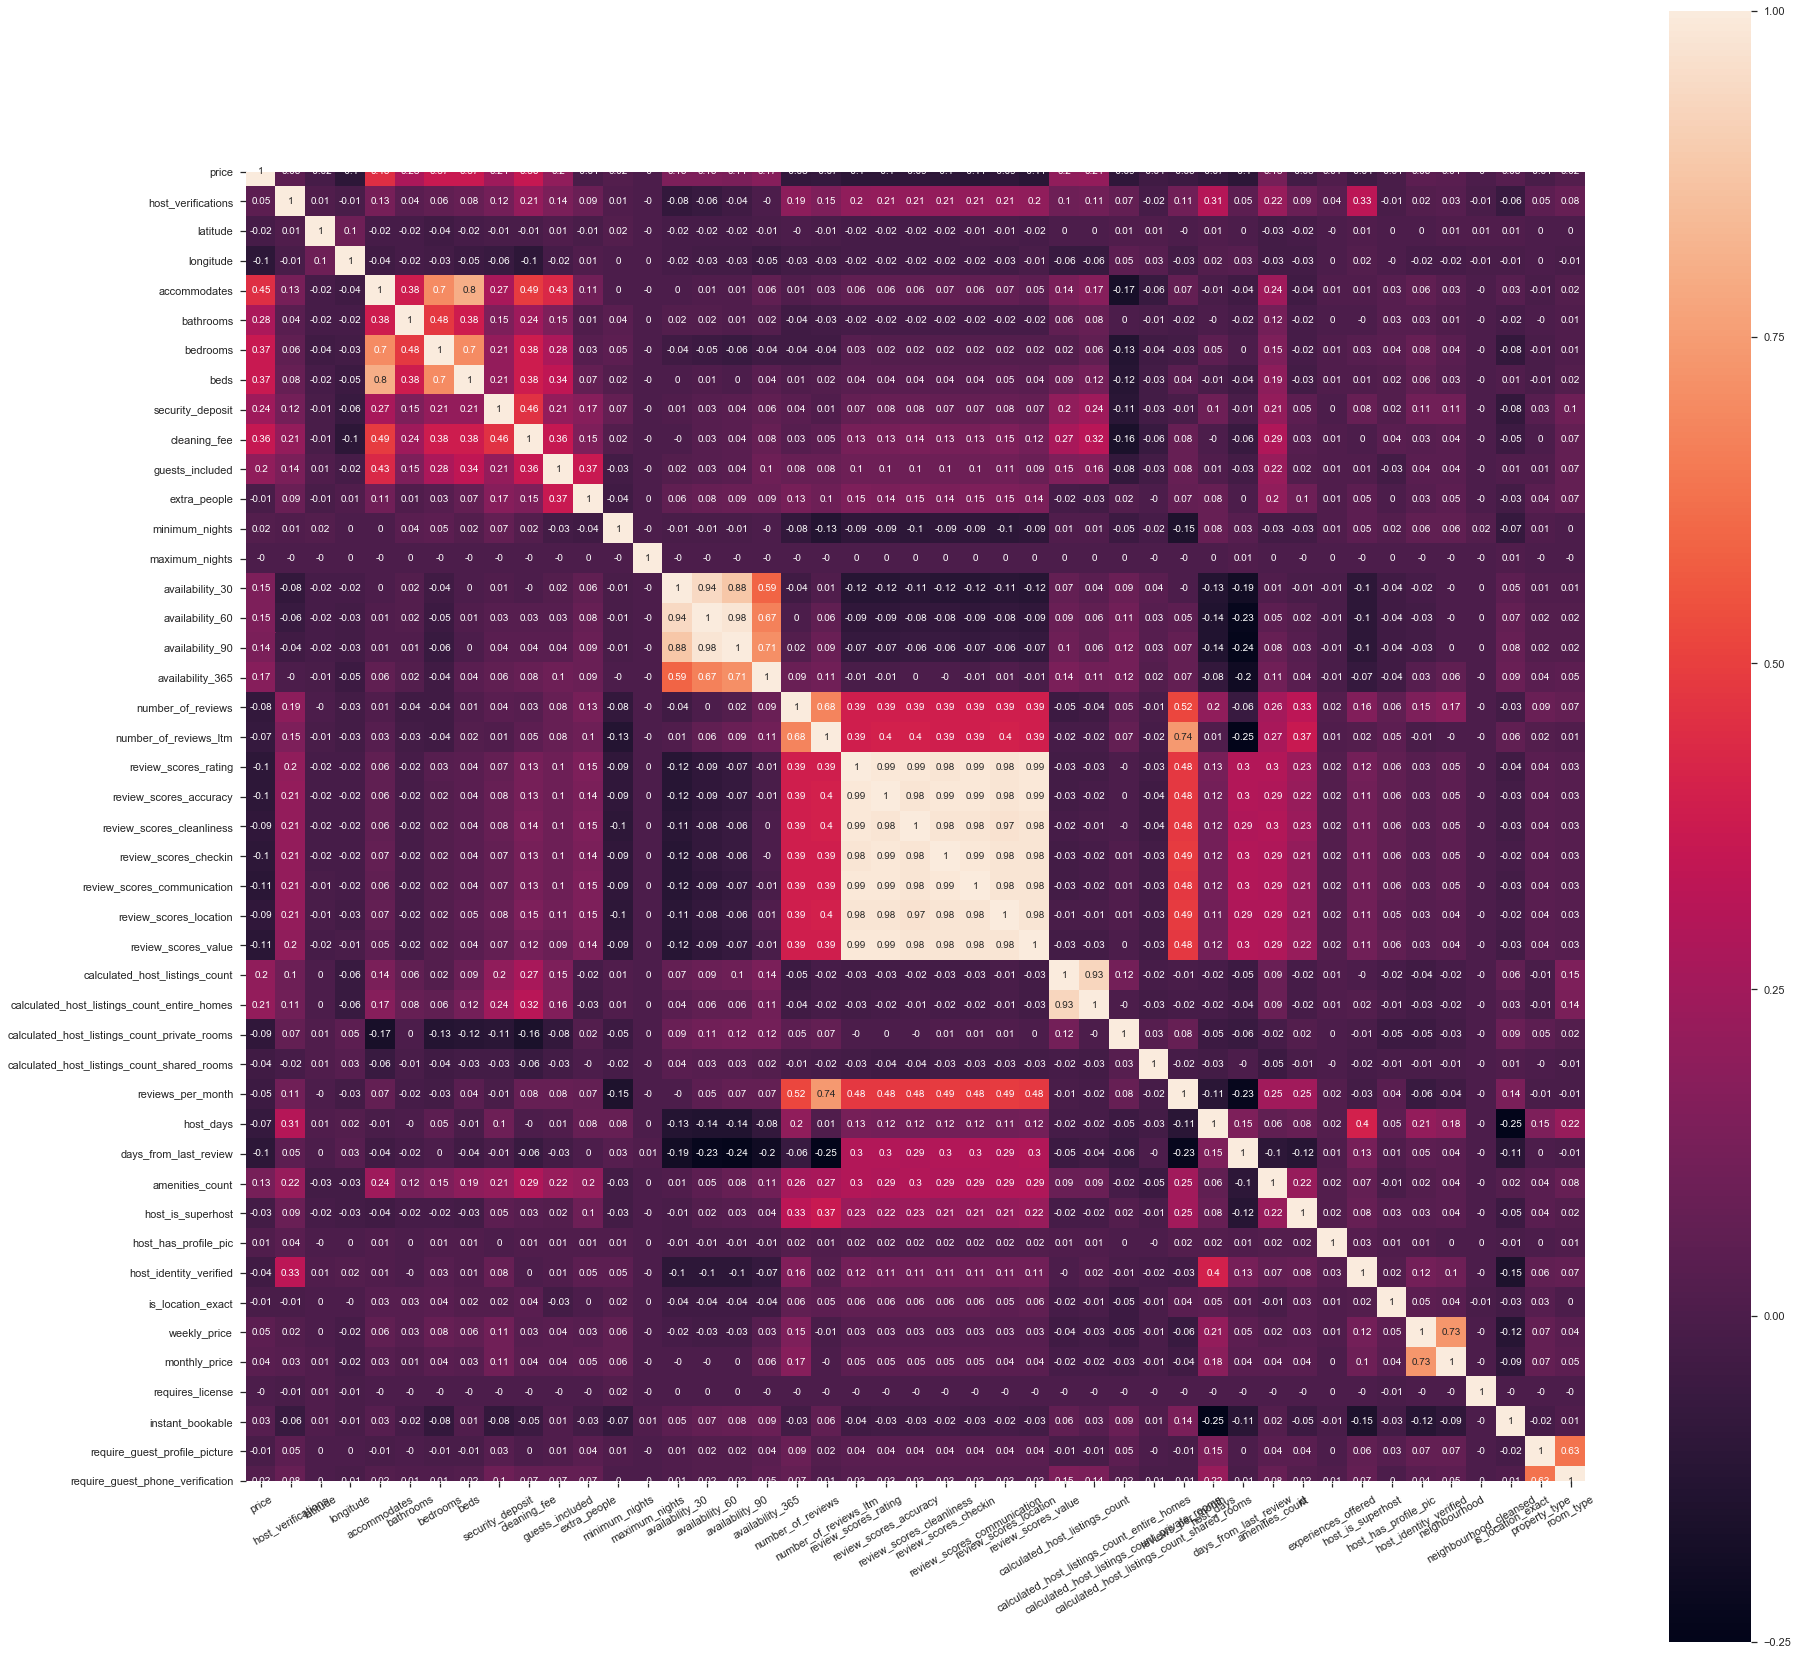

In [32]:
#We then check the correlation matrix of our final data

corr_table = round(df_londonairbnb_final.corr(), 2)
plt.figure(figsize=(30,30))
g = sns.heatmap(corr_table, xticklabels=corr_table.columns, yticklabels=corr_table.columns, annot=True, square = "equal");
g.set_xticklabels(list(df_londonairbnb_final.columns), rotation = 30);

In [36]:
display(eda.corr_table(df_londonairbnb_final, "price", n = 20))

Top  20 variables correlated with  price :


,price
accommodates,0.453604
beds,0.371424
bedrooms,0.365323
cleaning_fee,0.361749
bathrooms,0.281905
security_deposit,0.241439
calculated_host_listings_count_entire_homes,0.206383
guests_included,0.204517
calculated_host_listings_count,0.196863
availability_365,0.165827


As expected, the number of persons a property can accommodate, beds, bedrooms, bathrooms and cleaning, security and additional guest fees, though weak, are positively correlated with price.  Suprisingly, the review scores, though again weak, are negatively correlated.

In [35]:
display(eda.corr_table(df_londonairbnb_final, "review_scores_rating", n = 20))

Top  20 variables correlated with  review_scores_rating :


,review_scores_rating
review_scores_accuracy,0.990965
review_scores_value,0.989061
review_scores_communication,0.987685
review_scores_cleanliness,0.987268
review_scores_checkin,0.984800
review_scores_location,0.980476
reviews_per_month,0.478080
number_of_reviews_ltm,0.389851
number_of_reviews,0.386623
days_from_last_review,0.299726


Overall rating are positively correlated with number of reviews (total, per month and for the last 12 months) and of amenities. 

Individual scores on accuracy, communication, value, cleanliness, checkin-process, location will be excluded from the pricing model as these are highly correlated with the overall rating. 

In [37]:
display(eda.corr_table(df_londonairbnb_final, "host_is_superhost", n = 20))

Top  20 variables correlated with  host_is_superhost :


,host_is_superhost
number_of_reviews_ltm,0.365395
number_of_reviews,0.326931
reviews_per_month,0.254369
review_scores_cleanliness,0.228188
review_scores_rating,0.225275
amenities_count,0.223269
review_scores_value,0.222348
review_scores_accuracy,0.219657
review_scores_checkin,0.212976
review_scores_communication,0.212608


Superhost status is also positively correlated with number of reviews (total, per month and for the last 12 months) and of amenities and review scores.

### TEXT HERE

In [107]:
#For our first model, let's use all predictors except for those listed in 'X_columns_exlude'

X_columns_exlude = ['id', 'neighbourhood', 'weekly_price', 'monthly_price', 'availability_30', 'availability_60', 'availability_90', 
                    'price', 'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms',
                    'review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin', 'calculated_host_listings_count_shared_rooms', 
                    'review_scores_communication', 'review_scores_location','review_scores_value','minimum_nights', 'maximum_nights']

X = df_londonairbnb_final.drop(columns = X_columns_exlude, axis=1)
y = df_londonairbnb_final[["price"]]

model1 = pd.concat([y,X], axis = 1)

In [108]:
#Preprocess the X and y, scale continuous and encode categorcial featurs

X_train, X_test, y_train, y_test = reg.preprocess(X, y)

{'training_r^2': 0.3970578098198738, 'mse_train': 5843.413362438319, 'testing_r^2': -2.8265906369031532e+16, 'mse_test': 2.670576282251155e+20}


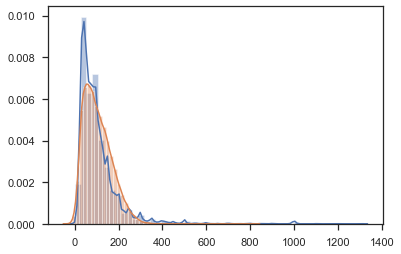

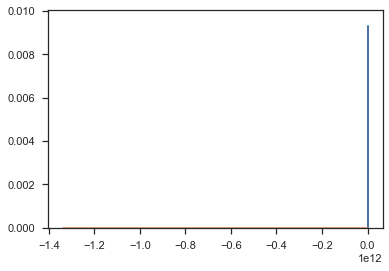

In [109]:
#First, let's run a Linear Regression Model

train_R2, test_R2, train_mse, test_mse, coefs, intercept = reg.run_linear(X_train, X_test, y_train, y_test)

In [110]:
# crossvalidation = KFold(n_splits=5, shuffle=True, random_state=10)
# baseline = np.mean(cross_val_score(regression, X_train, y_train, scoring="r2", cv=crossvalidation))

Our initial model using linear regression is not good as the R^2 is negative. We will then try Ridge and Lasso to help tackle multicollinearity and feature selection.

In [111]:
#Run Ridge regression on the same scaled and encoded train-test data

ridge_table = reg.run_ridge(X_train, X_test, y_train, y_test)
ridge_table.head()

,alpha,training_r^2,mse_train,testing_r^2,mse_test,intercept,coefficients
1,0.201005,0.397076,5843.239714,0.403356,5637.121602,[204.0778655004702],[[-0.17589988332...
2,0.402010,0.397052,5843.471157,0.403085,5639.676638,[199.66617261928...,[[-0.17407031212...
3,0.603015,0.397019,5843.786467,0.402829,5642.104500,[195.68636307256...,[[-0.17252180478...
4,0.804020,0.396981,5844.153647,0.402585,5644.405524,[192.08627822828...,[[-0.17119832920...
5,1.005025,0.396940,5844.552185,0.402354,5646.584404,[188.81798153238...,[[-0.17005932101...


{'alpha': 0.20100502512562815, 'training_r^2': 0.3970757273793598, 'mse_train': 5843.239714436524, 'testing_r^2': 0.40335592560154043, 'mse_test': 5637.121602369524}


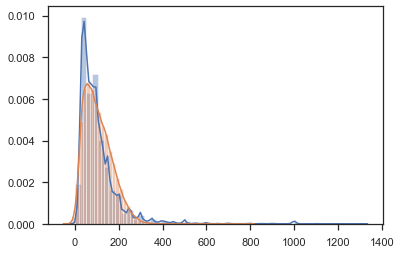

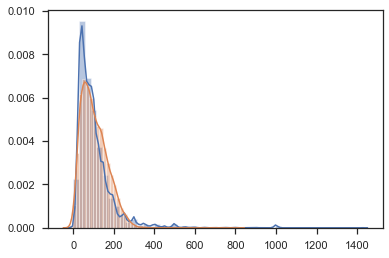

This model has  121  features vs  121  original features


,predictor,coef
0,host_verifications,-0.175900
1,latitude,-1.670317
2,longitude,4.841952
3,accommodates,14.774851
4,bathrooms,10.880048
...,...,...
116,cancellation_pol...,-104.857686
117,cancellation_pol...,-127.100710
118,cancellation_pol...,-100.329384
119,cancellation_pol...,-54.142973


In [112]:
reg.ridge_coef(ridge_table, X_train, X_test, y_train, y_test)

Ridge produced a better model (vs initial model above) with an alpha = 0.20.  No features were removed.

In [113]:
#Run LASSO regression on the same scaled and encoded train-test data

lasso_table = reg.run_lasso(X_train, X_test, y_train, y_test)
lasso_table.head()

,alpha,training_r^2,mse_train,testing_r^2,mse_test,intercept,coefficients
0,0.000000,0.397086,5843.144941,0.403657,5634.280762,[93.95465929572299],[-0.178092643833...
1,0.201005,0.380886,6000.140105,0.379013,5867.113232,[114.93809907974...,"[-0.0, -2.553145..."
2,0.402010,0.372665,6079.815559,0.370076,5951.552966,[116.15586648654...,"[-0.0, -1.177711..."
3,0.603015,0.369298,6112.452260,0.366385,5986.425829,[115.65641964752...,"[-0.0, -0.597104..."
4,0.804020,0.365765,6146.686001,0.362644,6021.765357,[114.65304834359...,"[-0.0, -0.251827..."


{'alpha': 0.0, 'training_r^2': 0.3970855064004305, 'mse_train': 5843.144941067988, 'testing_r^2': 0.4036566057808259, 'mse_test': 5634.280761729711}


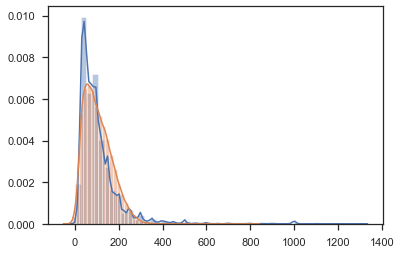

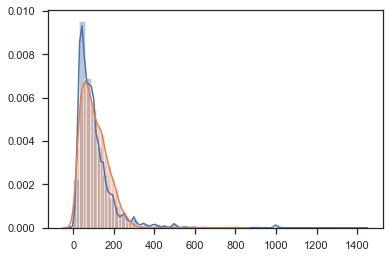

This model has  121  features vs  121  original features


,predictor,coef
0,host_verifications,-0.178093
1,latitude,-1.666073
2,longitude,4.880552
3,accommodates,14.778601
4,bathrooms,10.874740
...,...,...
116,cancellation_pol...,-4.012494
117,cancellation_pol...,-31.380964
118,cancellation_pol...,0.519386
119,cancellation_pol...,46.654578


In [114]:
reg.lasso_coef(lasso_table, X_train, X_test, y_train, y_test)

LASSO produced a better model than the linear model with an alpha very close to zero but not any better than Ridge.  No features were removed as well.

In [115]:
#Run Polynomial regression on the same scaled and encoded train-test data; degrees 2, 3, 4

#reg.run_poly(X, y)


# for degree in [2]:
#     # Instantiate PolynomialFeatures
#     poly = PolynomialFeatures(degree)

#     # Fit and transform X continuous
#     X_cf = X[[column for column in X.columns if X[column].dtype != "object"]]
#     X_cat = X[[column for column in X.columns if X[column].dtype == "object"]]
#     X_cf_poly = pd.DataFrame(data = poly.fit_transform(X_cf), columns = X_cf.columns)
#     X_poly = pd.concat([X_cf_poly, X_cat], axis = 1)

#     #split then scale and encode
#     X_poly_train, X_poly_test, y_train, y_test = preprocess(X_poly, y)

#     # Get predicted values for transformed polynomial test data
#     reg_poly = LinearRegression().fit(X_poly_train, y_train)

#     train_preds = reg_poly.predict(X_poly_train)
#     test_preds = reg_poly.predict(X_poly_test)                            

#     # Evaluate model performance on test data

#     train_R2 = r2_score(y_train, train_preds)
#     test_R2 = r2_score(y_test, test_preds)
#     train_mse = mean_squared_error(y_train, train_preds)
#     test_mse = mean_squared_error(y_test, test_preds)
#     coefs = reg_poly.coef_
#     intercept = reg_poly.intercept_
#     result_dict = {"degree": degree, "training_r^2": train_R2, "mse_train": train_mse, "testing_r^2": test_R2, "mse_test": test_mse}
#     print(result_dict)

#     # Create plot of predicted values
#     sns.distplot(y_train)
#     sns.distplot(train_preds)
#     plt.show();
#     sns.distplot(y_test)
#     sns.distplot(test_preds)
#     plt.show();

In [116]:
df_home = df_londonairbnb.query("room_type == 'Entire home/apt'")
df_home_cf = df_home.select_dtypes(["int64","float64"]).drop(["host_is_superhost", "host_has_profile_pic", "host_identity_verified", "is_location_exact", "require_guest_phone_verification",
         "require_guest_profile_picture", "instant_bookable", "requires_license","weekly_price", "monthly_price"], axis = 1)
df_home_cf_cleaned = df_home_cf[(np.abs(stats.zscore(df_home_cf)) < 3).all(axis = 1)]
df_home_final = pd.concat([df_home_cf_cleaned.price, df_home_cf_cleaned.drop(["price"], axis = 1), df_home.drop(df_home_cf_cleaned.columns, axis = 1)], axis = 1, join = "inner")
df_home_final.head()

,price,host_verifications,latitude,longitude,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_days,days_from_last_review,amenities_count,id,experiences_offered,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,is_location_exact,property_type,room_type,bed_type,weekly_price,monthly_price,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
2,100.0,5,51.48796,-0.16898,2.0,1.0,1.0,1.0,150.0,50.0,2.0,0.0,30.0,50.0,8.0,8.0,8.0,114.0,87.0,6.0,96.0,10.0,10.0,10.0,10.0,10.0,9.0,1.0,1.0,0.0,0.0,0.73,3571.0,19.0,29,15400,romantic,1,1,1,Chelsea,Kensington and C...,1,Apartment,Entire home/apt,Real Bed,600.0,2250.0,0,1,strict_14_with_g...,1,1
3,300.0,9,51.52098,-0.14002,6.0,2.0,3.0,4.0,350.0,65.0,4.0,10.0,3.0,365.0,12.0,36.0,54.0,265.0,41.0,5.0,94.0,10.0,9.0,9.0,9.0,10.0,9.0,15.0,15.0,0.0,0.0,0.40,3541.0,88.0,31,17402,none,1,1,1,City of Westminster,Westminster,1,Apartment,Entire home/apt,Real Bed,1378.0,0.0,0,1,strict_14_with_g...,0,0
7,147.0,8,51.54168,-0.10207,4.0,1.0,1.0,3.0,100.0,75.0,3.0,15.0,3.0,365.0,13.0,34.0,64.0,339.0,63.0,9.0,85.0,8.0,9.0,9.0,9.0,9.0,8.0,3.0,3.0,0.0,0.0,0.58,3436.0,55.0,36,26223,none,0,1,1,LB of Islington,Islington,1,Apartment,Entire home/apt,Real Bed,727.0,2747.0,0,1,strict_14_with_g...,0,0
11,195.0,6,51.47934,-0.28066,5.0,1.5,3.0,3.0,0.0,0.0,1.0,0.0,3.0,22.0,5.0,23.0,53.0,319.0,74.0,17.0,97.0,10.0,10.0,10.0,10.0,10.0,9.0,1.0,1.0,0.0,0.0,0.68,3364.0,14.0,39,36299,none,1,1,1,LB of Richmond u...,Richmond upon Th...,1,Townhouse,Entire home/apt,Real Bed,0.0,0.0,0,0,moderate,0,0
13,80.0,6,51.53972,-0.05885,2.0,1.0,1.0,1.0,0.0,30.0,1.0,0.0,6.0,21.0,9.0,32.0,62.0,62.0,52.0,1.0,97.0,10.0,9.0,10.0,10.0,10.0,10.0,1.0,1.0,0.0,0.0,0.47,3358.0,169.0,21,36986,none,0,1,1,Hackney,Hackney,0,Apartment,Entire home/apt,Real Bed,650.0,0.0,0,0,strict_14_with_g...,0,0


Linear Regression: 
{'training_r^2': 0.40852742245167056, 'mse_train': 8029.807937461206, 'testing_r^2': -6.46215170251702e+19, 'mse_test': 8.163671356293492e+23}


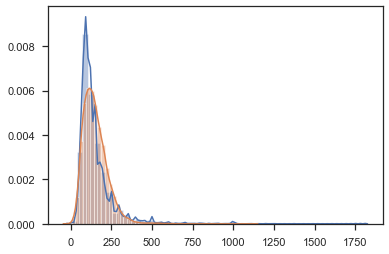

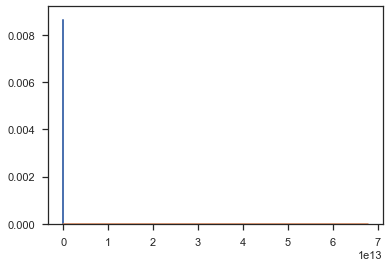

Ridge Regression: 
{'alpha': 0.20100502512562815, 'training_r^2': 0.4090841137447854, 'mse_train': 8022.250318843113, 'testing_r^2': 0.41115054218297453, 'mse_test': 7438.967194282053}


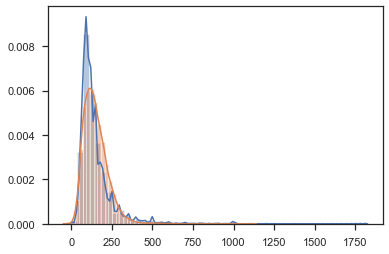

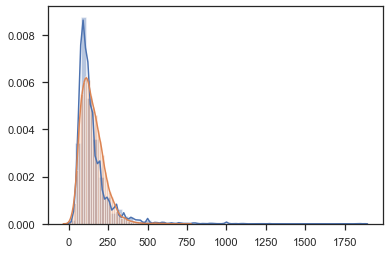

This model has  97  features vs  99  original features
LASSO Regression: 
{'alpha': 0.0, 'training_r^2': 0.40909159122060257, 'mse_train': 8022.148804931991, 'testing_r^2': 0.41114018813350184, 'mse_test': 7439.097997551604}


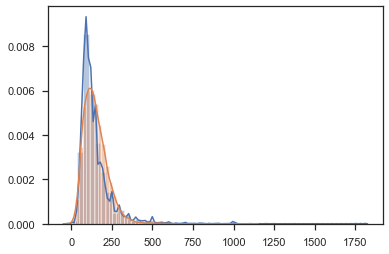

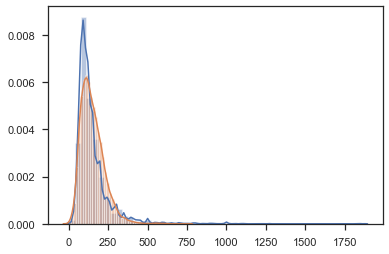

This model has  97  features vs  99  original features


,predictor,coef
0,host_verifications,1.084165
1,latitude,-5.594123
2,longitude,19.300428
3,accommodates,10.051066
4,bathrooms,23.386096
...,...,...
94,cancellation_pol...,-6.129266
95,cancellation_pol...,-63.772360
96,cancellation_pol...,-5.484093
97,cancellation_pol...,5.642247


In [117]:
#Run linear, Ridge and LASSO for the same set of features

X = df_home_final.drop(columns = X_columns_exlude, axis=1)
y = df_home_final[["price"]]

X_train, X_test, y_train, y_test = reg.preprocess(X, y)

print("Linear Regression: ")
train_R2, test_R2, train_mse, test_mse, coefs, intercept = reg.run_linear(X_train, X_test, y_train, y_test)

print("Ridge Regression: ")
ridge_table = reg.run_ridge(X_train, X_test, y_train, y_test)
reg.ridge_coef(ridge_table, X_train, X_test, y_train, y_test)

print("LASSO Regression: ")
lasso_table = reg.run_lasso(X_train, X_test, y_train, y_test)
reg.lasso_coef(lasso_table, X_train, X_test, y_train, y_test)